Throne2Vec
=============

### Training a word2vec model on a data-set made out of the entire Game of Thrones book collection

This notebook is based on assignment 5 of the Udacity Deep-Learning course:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb

Besides the data-set, what is new here:
* Text Pre-Processing
* Finding word analogies using the learned embedding
* More comments
* Optimizations

In [2]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import pickle

In [4]:
# Tensorflow version used:
print(tf.__version__)

1.11.0


Read the data into a list of strings:

*The .zip file is not included in this repository due to book copyrights considerations, sorry about that.
However, you can create your own data-set with whichever book (or text in general) you'd like. Just make sure it is in a .zip file with one or more .txt files in it.*

In [42]:
filename = 'got_txt.zip'

def read_data(filename):
  """Extract the files enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = []
    for f_tag in f.namelist():
        data_tmp = tf.compat.as_str(f.read(f_tag)).split()
        data += data_tmp
  return data
  
words = read_data(filename)

# Print some words and the size of data-set:
print(words[:20])
print('Words in data-set: %d' % len(words))

['A', 'Game', 'Of', 'Thrones', 'Book', 'One', 'of', 'A', 'Song', 'of', 'Ice', 'and', 'Fire', 'By', 'George', 'R.', 'R.', 'Martin', 'PROLOGUE', '"We']
Words in data-set: 1789968


Edit the list of words to remove repetitions due to case sensetivity and pre\sufixes:

In [43]:
# Remove unwanted characters such as " , . ? ! etc'.
# Also remove blank words and set all characters to lower case
bad_chars = '—"”“,.)(?!; }{'  
for ch in bad_chars:
    # Todo: Try to implement this without going over all words len(bad_chars) times
    words = [s.replace(ch,'').lower() for s in words if s!=''] 

# Print some words
print(words[:50])
print('Data size %d' % len(words))


['a', 'game', 'of', 'thrones', 'book', 'one', 'of', 'a', 'song', 'of', 'ice', 'and', 'fire', 'by', 'george', 'r', 'r', 'martin', 'prologue', 'we', 'should', 'start', 'back', 'gared', 'urged', 'as', 'the', 'woods', 'began', 'to', 'grow', 'dark', 'around', 'them', 'the', 'wildlings', 'are', 'dead', 'do', 'the', 'dead', 'frighten', 'you', 'ser', 'waymar', 'royce', 'asked', 'with', 'just', 'the']
Data size 1782555


Build the dictionary and replace rare words with UNK token.

In [44]:
vocabulary_size = 22000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))

  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary: 
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary
# data is a list of all word indexes (with repetitions)
# count is a list of touples(except for the first entry which is a list), each containing one of the
#   common words and the number of repetitions. in a descending order
# dictionary contains all common words(keys) and a unique index for each word(value). 'UNK' has index 0.
# reverse_dictionary reverses the key\value

data, count, dictionary, reverse_dictionary = build_dataset(words_clean_filtered)
print('Most common words (+UNK)', count[:50])
print('Sample data', data[:10])

# del words_clean_filtered  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 7820], ('the', 104135), ('and', 52271), ('a', 40542), ('to', 40036), ('of', 37652), ('he', 27806), ('his', 26576), ('was', 22077), ('you', 19310), ('her', 19197), ('i', 18980), ('in', 18105), ('had', 17020), ('it', 16373), ('that', 15884), ('as', 15150), ('she', 14836), ('with', 13285), ('him', 12484), ('not', 11787), ('but', 11307), ('for', 10935), ('is', 9206), ('they', 8998), ('on', 8971), ('at', 8854), ('said', 8744), ('have', 8591), ('my', 8588), ('be', 8061), ('them', 7847), ('no', 7648), ('lord', 7561), ('from', 7381), ('would', 7042), ('were', 7023), ('me', 6962), ('your', 6644), ('all', 6377), ('when', 6324), ('one', 6245), ('will', 6236), ('if', 6011), ('ser', 5876), ('so', 5778), ('their', 5410), ('could', 5089), ('are', 4970), ('this', 4453)]
Sample data [3, 990, 5, 3253, 1272, 41, 5, 3, 628, 5]


Function to generate a training batch for the skip-gram model.

In [45]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
#   print(batch,labels)

  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['a', 'game', 'of', 'thrones', 'book', 'one', 'of', 'a']

with num_skips = 2 and skip_window = 1:
    batch: ['game', 'game', 'of', 'of', 'thrones', 'thrones', 'book', 'book']
    labels: ['a', 'of', 'game', 'thrones', 'book', 'of', 'one', 'thrones']

with num_skips = 4 and skip_window = 2:
    batch: ['of', 'of', 'of', 'of', 'thrones', 'thrones', 'thrones', 'thrones']
    labels: ['game', 'book', 'thrones', 'a', 'one', 'game', 'of', 'book']


Train a skip-gram model.

In [46]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
num_skips = 4 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
validation_size = 12 # Random set of words to evaluate similarity on.
validation_window = 100 # Only pick dev samples in the head of the distribution.
validation_examples = np.array(random.sample(range(validation_window), validation_size))

# Override validation set:
validation_words = ['king','jon','death','tyrion','fire','war','dragons','winter','guard','wolf','father','faces']
validation_index = [dictionary[w] for w in validation_words]
validation_examples = np.array(validation_index)

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  validation_dataset = tf.constant(validation_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases,train_labels, embed,
                               num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  global_step = tf.Variable(0, name='global_step', trainable=False)

  LR = tf.train.exponential_decay(1.0, global_step, 50000, 0.8, staircase=True)

#   optimizer = tf.train.AdagradOptimizer(LR).minimize(loss, global_step=global_step)
#   optimizer = tf.train.AdamOptimizer(LR).minimize(loss, global_step=global_step)
  optimizer = tf.train.AdagradOptimizer(2.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  validation_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, validation_dataset)
  similarity = tf.matmul(validation_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [47]:
num_steps = 1000001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l, lr_ = session.run([optimizer, loss,LR], feed_dict=feed_dict)
    average_loss += l
    if step % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 5000
      # The average loss is an estimate of the loss over the last 5000 batches.
      print('Average loss at step %d: %f. lr = %f' % (step, average_loss,lr_))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 40000 == 0:
      sim = similarity.eval()
      for i in range(validation_size):
        validation_word = reverse_dictionary[validation_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % validation_word
        for k in range(top_k):
#           print(nearest[k])
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.157095. lr = 1.000000
Nearest to king: vair-lined, shrugging, simplicity, homvale, activity, puffing, reznak’s, villagers,
Nearest to jon: fronted, sounds, evidence, cuff, position, dropped, dowager, great-grandson,
Nearest to death: misgivings, badger, lizard-lions, swat, waters, heraldry, sluts, bull,
Nearest to tyrion: wrenched, diggers, mandrake, pleasured, resin, regrow, gift:, leered,
Nearest to fire: number, today's, outcries, anvil, obliged, anders’s, decisions, only,
Nearest to war: errant, awfully, pearl, wears, reemerge, aerys's, forked, hell’s,
Nearest to dragons: vacuous, rung, erren, where, handsomely, surviving, consequence, placate,
Nearest to winter: vales, smuggler, betters, clings, magnar’s, pricking, judge, clothe,
Nearest to guard: dishonor, 503, goldengrove, seehowshe, rangers, warn, ecstasy, contemplate,
Nearest to wolf: arbor’s, retinue, half-familiar, fool’s, ordered, conceive, blotted, entails,
Nearest to father: seaworth’

Average loss at step 205000: 3.594281. lr = 1.000000
Average loss at step 210000: 3.558429. lr = 1.000000
Average loss at step 215000: 3.595186. lr = 1.000000
Average loss at step 220000: 3.572438. lr = 1.000000
Average loss at step 225000: 3.520470. lr = 1.000000
Average loss at step 230000: 3.564284. lr = 1.000000
Average loss at step 235000: 3.513352. lr = 1.000000
Average loss at step 240000: 3.553620. lr = 1.000000
Nearest to king: usurper, baratheon, aerys, realm, traitor, beloved, legend, brother,
Nearest to jon: hake, hoster, snow, catelyn, gold-flecked, greenpools, ned, -tygett's,
Nearest to death: prophecy, taste, panic, life, gash, warharnmer, retribution, reek’s,
Nearest to tyrion: sansa, merrett, harry, tywin, 61, discussions, jaime, dwarf,
Nearest to fire: leaked, bad, flame, fires, orange, flames, pork, globs,
Nearest to war: outcome, clank, acknowledgment, battle's, deed, tradesman-captain, abbatoir, wars,
Nearest to dragons: treasons, indistinct, horselines, spate, con

Average loss at step 445000: 3.482727. lr = 1.000000
Average loss at step 450000: 3.495277. lr = 1.000000
Average loss at step 455000: 3.478169. lr = 1.000000
Average loss at step 460000: 3.488359. lr = 1.000000
Average loss at step 465000: 3.429026. lr = 1.000000
Average loss at step 470000: 3.472019. lr = 1.000000
Average loss at step 475000: 3.409928. lr = 1.000000
Average loss at step 480000: 3.466004. lr = 1.000000
Nearest to king: usurper, queen, judges, baratheon, reign, beloved, realm, tommen,
Nearest to jon: snow, robert, lysa, catelyn, ryk, darlessa, erik’s, sardonic,
Nearest to death: life, stannis, prophecy, swimming, retribution, brimstone, self, bump,
Nearest to tyrion: patchface, taena, dwarf, cersei, sansa, catelyn, davos, indifference,
Nearest to fire: leaked, fires, tainted, darkness, candle, flame, chill, flames,
Nearest to war: fighting, isle, tradesman-captain, kingdom, unsatisfactory, wars, ancient, outcome,
Nearest to dragons: leviathan, spate, islanders, truths,

Average loss at step 685000: 3.430055. lr = 1.000000
Average loss at step 690000: 3.451121. lr = 1.000000
Average loss at step 695000: 3.431666. lr = 1.000000
Average loss at step 700000: 3.443120. lr = 1.000000
Average loss at step 705000: 3.388782. lr = 1.000000
Average loss at step 710000: 3.424231. lr = 1.000000
Average loss at step 715000: 3.364109. lr = 1.000000
Average loss at step 720000: 3.427334. lr = 1.000000
Nearest to king: usurper, queen, baratheon, targaryen, realm, aerys, forager, reign,
Nearest to jon: snow, widow, catelyn, 583, ygritte, -did, ned, erik’s,
Nearest to death: life, belly, stannis, presence, lorch, gout, seventeenth, corbray,
Nearest to tyrion: cersei, dwarf, jaime, brienne, tywin, merrett, catelyn, indifference,
Nearest to fire: candle, flames, torches, flame, hot, fires, peat, candles,
Nearest to war: abbatoir, kingdom, battle's, tradesman-captain, assume, fighting, battle, great,
Nearest to dragons: leviathan, things, sequential, goat-helmed, bells, tr

Average loss at step 925000: 3.393171. lr = 1.000000
Average loss at step 930000: 3.430910. lr = 1.000000
Average loss at step 935000: 3.401146. lr = 1.000000
Average loss at step 940000: 3.424129. lr = 1.000000
Average loss at step 945000: 3.365801. lr = 1.000000
Average loss at step 950000: 3.400478. lr = 1.000000
Average loss at step 955000: 3.348932. lr = 1.000000
Average loss at step 960000: 3.392515. lr = 1.000000
Nearest to king: queen, usurper, baratheon, tommen, crow’s, statue, forager, realm,
Nearest to jon: snow, catelyn, robert, ned, ygritte, ryk, theon, alliser,
Nearest to death: life, presence, seventeenth, smallford, white-hot, gout, minded, stannis,
Nearest to tyrion: cersei, brienne, jaime, indifference, dwarf, cyvasse, davos, catelyn,
Nearest to fire: flames, tainted, torches, bloodred, hardskin, candle, peat, flame,
Nearest to war: wars, battle, fighting, march, kingdom, battle's, abbatoir, unsatisfactory,
Nearest to dragons: it', leviathan, things, correctly, sequen

Save the results:


In [48]:
embed_file_name = 'embed1M_v2.pickle'
with open(embed_file_name, 'wb') as f:  
    pickle.dump(final_embeddings, f)

In case you want to load existing embeddings:

In [64]:
embed_file_name = 'embed1M_v2.pickle'
with open(embed_file_name,'rb') as f:  
    final_embeddings = pickle.load(f)

To visualize the learned embeddings we will use TSNE to create a projection from out multi-dimensional space to a 2D space:

In [60]:
num_points = 1000
un_interesting_words = 60 # the most common words are usually very generic and not so interesting (I, you, is, the etc.)
tsne = TSNE(perplexity=20, n_components=2, init='pca', n_iter=20000)
two_d_embeddings = tsne.fit_transform(final_embeddings[un_interesting_words:num_points+un_interesting_words, :])

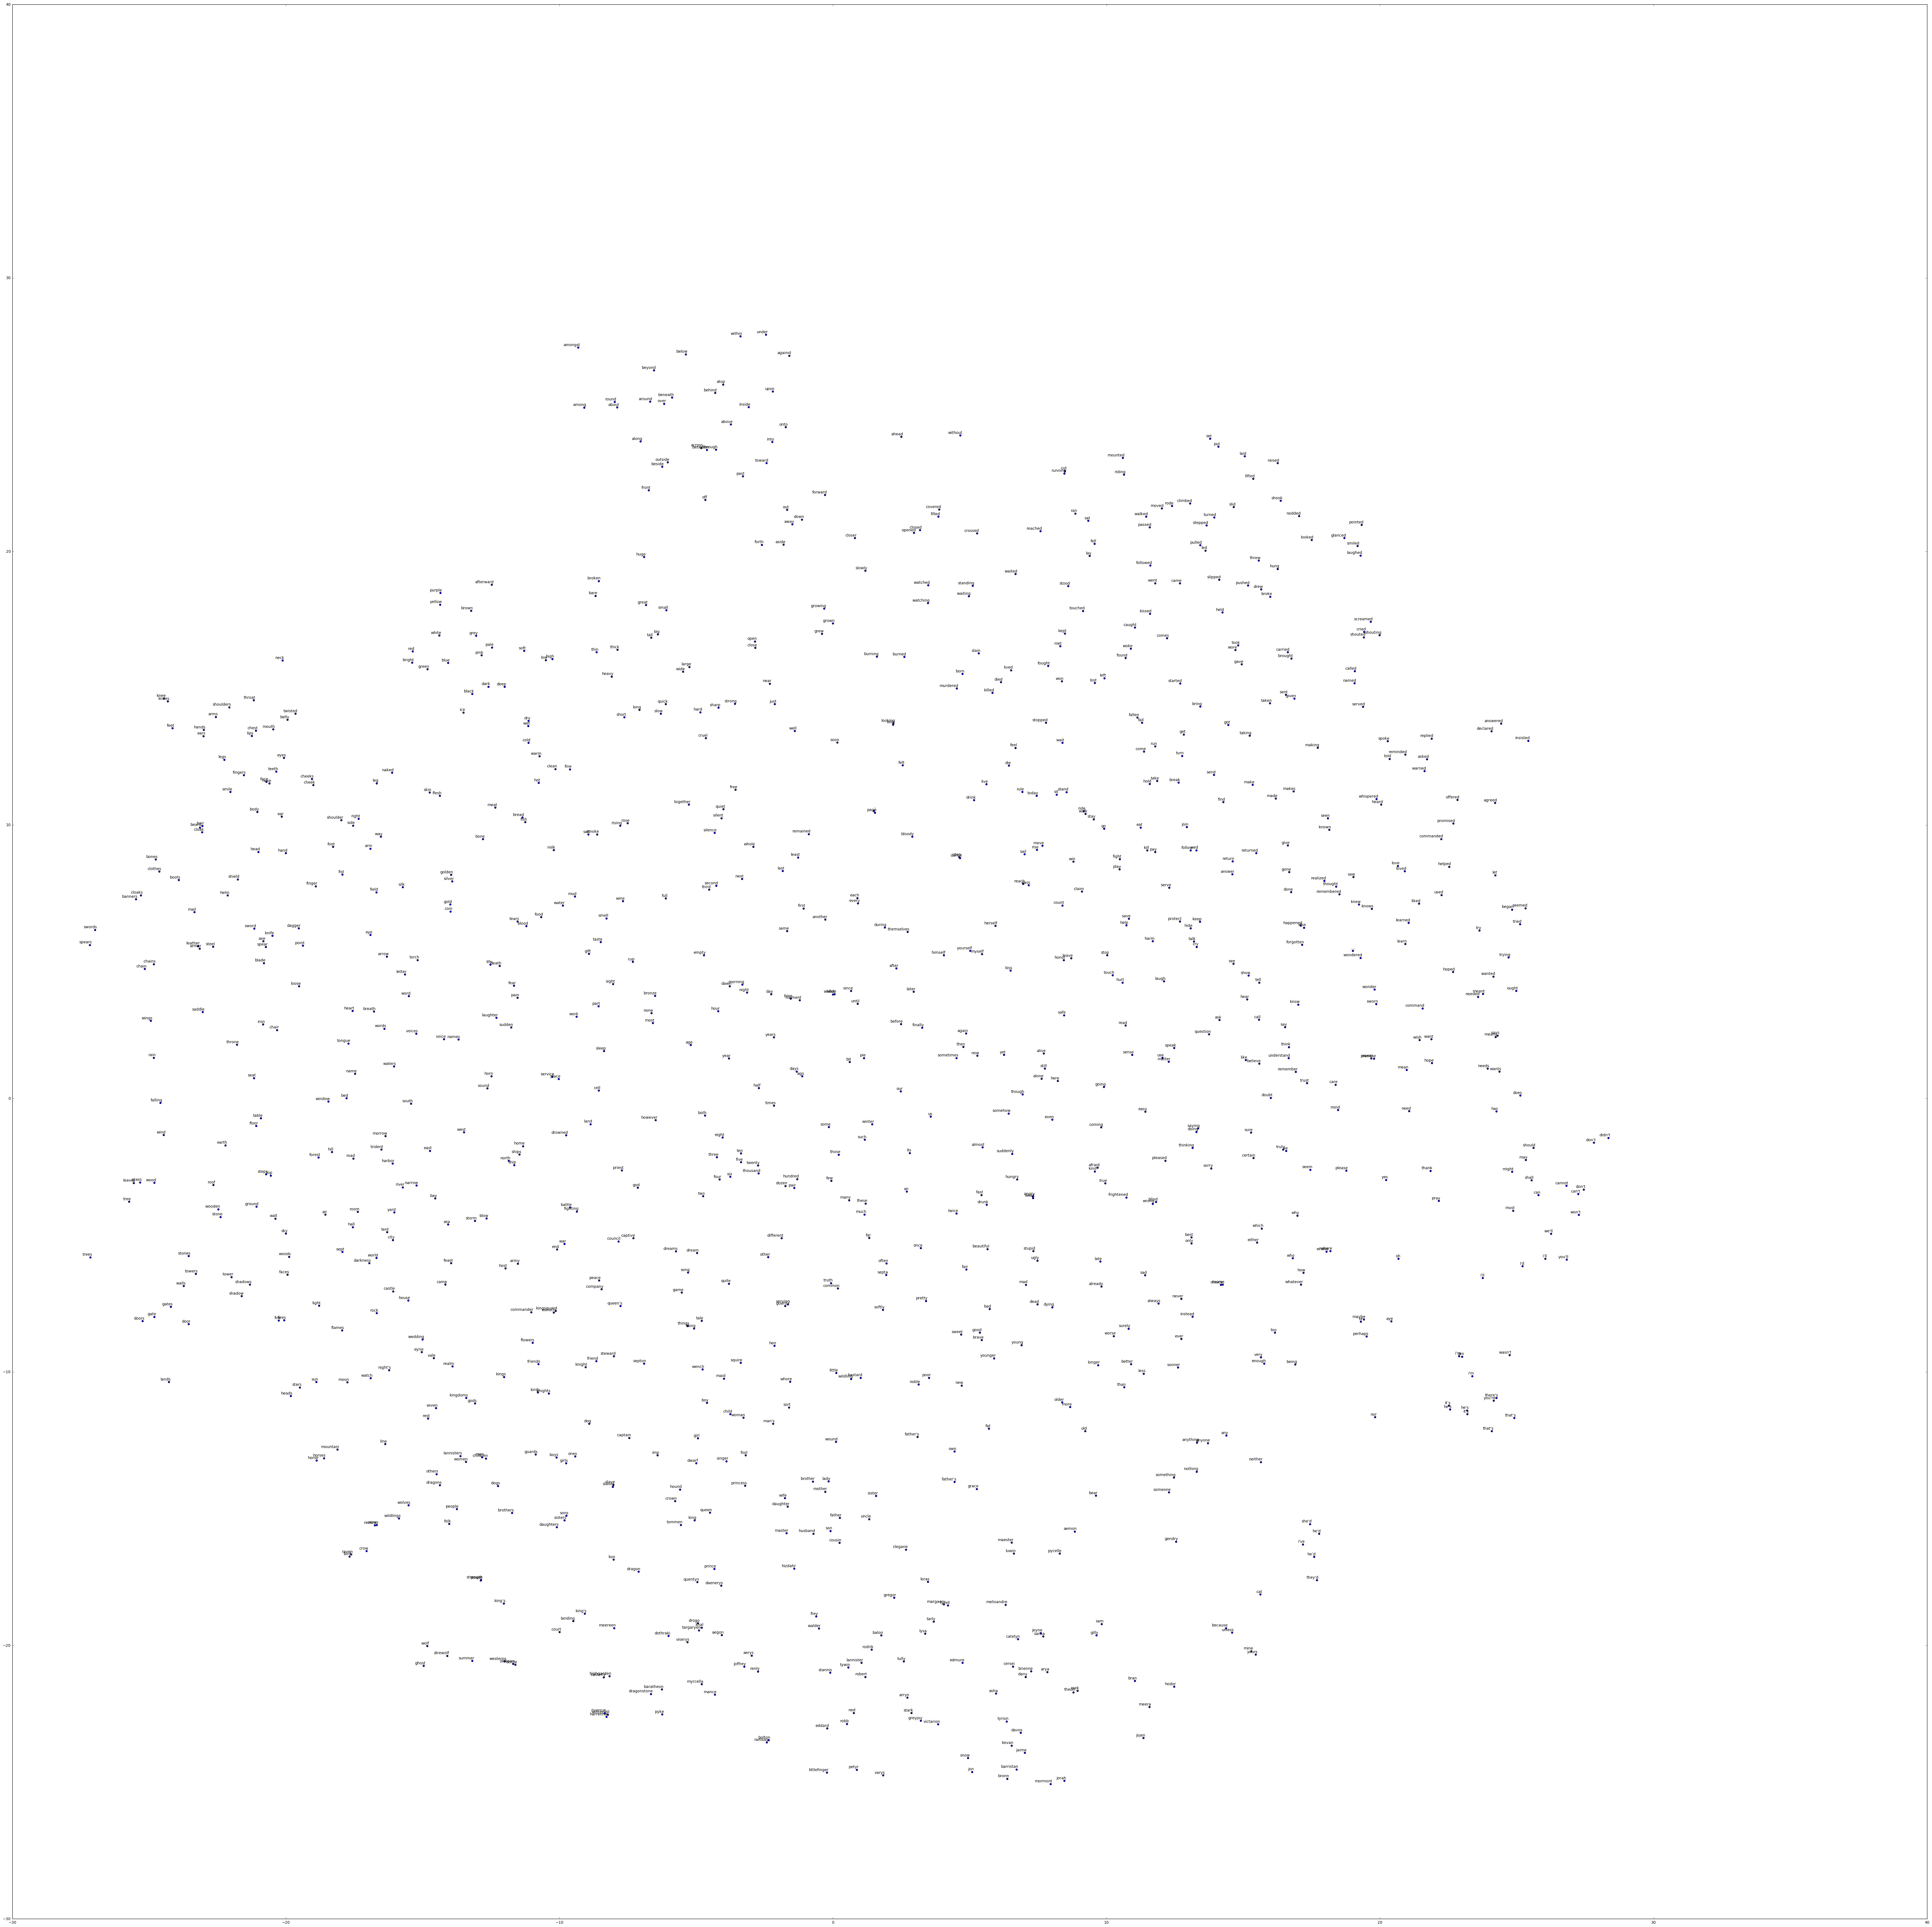

In [313]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(90,90))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(un_interesting_words, num_points+un_interesting_words)]
plot(two_d_embeddings, words)

#### Let's play around with the results:

## Word Analogies
One of the coolest things about word2vec is the ability to observe interesting relations between different words using simple mathematical operations.

We can use this property to answer a question such as: A __queen__ to a __king__ is like a __[word]__ to a __man__, finding the word closest (using cosine similarity distance) to the expression Queen - King + Man will give us the answer.

Since we are using Game of Thrones as our data-set, we can explore some really neat relations that our model has picked up.

Let's start with writing a function that finds the missing word in our analogy query:

In [65]:
def find_analogy(w1,w2,w3,final_embed,crop_bottom,reverse_dictionary):
    example_words = np.array([w1-crop_bottom,w2-crop_bottom,w3-crop_bottom])
    example_tensor = tf.constant(example_words, dtype=tf.int32)
    example_embeddings = tf.nn.embedding_lookup(
        final_embed, example_tensor)
    w1_emb, w2_emb, w3_emb = tf.split(example_embeddings, num_or_size_splits=3, axis=0)
    y = w2_emb-w1_emb+w3_emb
    y_norm = tf.sqrt(tf.reduce_sum(tf.square(y), 1, keep_dims=True))
    y = y/y_norm
    similarity_example = tf.matmul(y, tf.transpose(final_embed))
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        sim = similarity_example.eval()
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[0,:]).argsort()[0:top_k+1]
    #     print(nearest)
        flag_first = 0
        for k in range(top_k):
          word_idx = nearest[k]+crop_bottom
          if word_idx not in [w1,w2,w3]:
              close_word = reverse_dictionary[word_idx]
              if flag_first==0:
                  print('Query: \n', reverse_dictionary[w2],' to ', reverse_dictionary[w1],' is like ______ to ',reverse_dictionary[w3],'\n')
                  print('Result:\n',reverse_dictionary[w2],' to ', reverse_dictionary[w1],' is like ',close_word,' to ',reverse_dictionary[w3],'\n')
                  flag_first = 1
                  print('Nearest words:')

              print(close_word)
#         print(nearest+crop_bottom)
    print('\n')
    return similarity_example


In [66]:
with graph.as_default():
    num_points = 1100 # Use only common words, reduces noise.
    
    crop_bottom = 30 # Ignore most common words (ptobably a,the, I etc.)
    embed_tst = tf.constant(final_embeddings[crop_bottom:crop_bottom+num_points, :])

First, let's try a sanity check, with non GOT related analogies: 

In [67]:
with graph.as_default():

    w1 = dictionary['king']
    w2 = dictionary['queen']
    w3 = dictionary['man'] 
    similarity_example = find_analogy(w1,w2,w3,embed_tst,crop_bottom,reverse_dictionary)

    w1 = dictionary['good']
    w2 = dictionary['better']
    w3 = dictionary['bad']
    
    similarity_example = find_analogy(w1,w2,w3,embed_tst,crop_bottom,reverse_dictionary) 
    

Query: 
 queen  to  king  is like ______ to  man 

Result:
 queen  to  king  is like  woman  to  man 

Nearest words:
woman
girl
thing


Query: 
 better  to  good  is like ______ to  bad 

Result:
 better  to  good  is like  worse  to  bad 

Nearest words:
worse
marriage
fight




We can see our model 'knows' that a woman to a man is like a queen to a king, also it picked up on the fact that worse to bad is like better to good. 

Now let's try something trickier, what does our model know about the characters from GOT?

In [76]:
with graph.as_default():

    w1 = dictionary['dany']
    w2 = dictionary['khaleesi']
    w3 = dictionary['petyr']
    similarity_example = find_analogy(w1,w2,w3,embed_tst,crop_bottom,reverse_dictionary)



Query: 
 khaleesi  to  dany  is like ______ to  petyr 

Result:
 khaleesi  to  dany  is like  littlefinger  to  petyr 

Nearest words:
littlefinger
tully
father's
wasn't




Cool! Dany's other name (one of many) is often Khaleesi. Similarly ,Petyr is known as 'littlefinger'.

Now let's see whet the model knows about family relations between characters:

In [427]:
with graph.as_default():

    w1 = dictionary['myrcella']
    w2 = dictionary['cersei']
    w3 = dictionary['sansa']
    similarity_example = find_analogy(w1,w2,w3,embed_tst,crop_bottom,reverse_dictionary)




Query: 
 cersei  to  myrcella  is like ______ to  sansa 

Result:
 cersei  to  myrcella  is like  catelyn  to  sansa 

Nearest words:
catelyn
arya
dany




Cersei is Myrcella's mother just as Catelyn is Sansa's mother :)

How about famliy names?

In [428]:
with graph.as_default():
    
    w1 = dictionary['rob']
    w2 = dictionary['stark']
    w3 = dictionary['theon']
    
    similarity_example = find_analogy(w1,w2,w3,embed_tst,crop_bottom,reverse_dictionary)


Query: 
 stark  to  rob  is like ______ to  theon 

Result:
 stark  to  rob  is like  greyjoy  to  theon 

Nearest words:
greyjoy
arya
jon




Spot on ;)

As a last example, we will let the model fit a place to a family. The Stark family (in case you don't know, they are also the luckiest family in the world and nothing bad ever happens to them) are from Winterfell. But who is originally from Highgarden?

In [429]:
with graph.as_default():
    w1 = dictionary['winterfell']
    w2 = dictionary['stark']
    w3 = dictionary['highgarden']
    
    similarity_example = find_analogy(w1,w2,w3,embed_tst,crop_bottom,reverse_dictionary)


Query: 
 stark  to  winterfell  is like ______ to  highgarden 

Result:
 stark  to  winterfell  is like  tyrell  to  highgarden 

Nearest words:
tyrell
lannisters
company




So our model learned some neat things about the world of GOT. Of course it is not perfect and the examples presented are the result of some cherry-picking, but feel free to play around with the examples and get a feel of how it works.